In [1]:
import pandas as pd
import json
import csv
import matplotlib.pyplot as plt
import numpy as np
import time
import datetime

def date2ts(date):
    return datetime.datetime.timestamp(datetime.datetime.strptime(date, "%Y/%m/%d %H:%M:%S"))

def ts2date(timestamp):
    return(datetime.datetime.fromtimestamp(timestamp).strftime('%Y-%m-%d %H:%M:%S'))

date2ts('2022/06/12 21:22:5')

1655040125.0

In [2]:
router_info = {
    '20080029c69feeb': {'lat': 22.3482, 'lon': 114.1955, 'name': '五芳街 沙田坳'},
    '20180029c69feeb': {'lat': 22.3482, 'lon': 114.1955, 'name': '五芳街 沙田坳'},
    '20080029c1e38f3': {'lat': 22.33859, 'lon': 114.19964, 'name': '五芳街'},
    '20080029c5e3677': {'lat': 22.34135, 'lon': 114.20243, 'name': 'Diamond Hill'},
    # '20180029c4574b6': {'lat': -1, 'lon': -1, 'name': '畢架山'},
    # '20080029c4574b6': {'lat': -1, 'lon': -1, 'name': '畢架山'},
    # '20080029c1ea300': {'lat': -1, 'lon': -1, 'name': 'Kowloon Bay'},
    '2005813d31be7ec': {'lat': 22.33668, 'lon': 114.19884, 'name': '八達街'},
    '20180029c7b7b60': {'lat': 22.32514, 'lon': 114.21082, 'name': 'Kowloon Bay(Metro Center 2)'},
    '20080029c69ffc2': {'lat': -22.31499, 'lon': 114.18307, 'name': '何文田邨適文樓'},
}

gt_distribution = {
    'diamond_200m': {'date': ['2022/07/06 10:58:00', '2022/07/06 11:08:00'], 'coor': [22.3412944950869, 114.20073744876093]},
    'dayoujie_500m': {'date': ['2022/07/06 11:24:00', '2022/07/06 11:34:00'], 'coor': [22.338186087878373, 114.19885639530463]},
    'huangdaxian_1000m': {'date': ['2022/07/19 10:40:00', '2022/07/19 10:50:00'], 'coor': [22.341840882178104, 114.19449022248844]},
    'fuhaodongfang_1500m': {'date': ['2022/07/06 17:10:00', '2022/07/06 17:20:00'], 'coor': [22.328988088616413, 114.1925017465669]},
    'songhuangtai_2000m': {'date': ['2022/07/06 18:16:00', '2022/07/06 18:26:00'], 'coor': [22.325466338854763, 114.19031932195354]},
}

gt_point = {
    'dayoujie': {'date': '2022/07/06 11:48:00','coor': [22.338173421484996, 114.20168251817528]},
    'caihong': {'date': '2022/07/06 11:56:00','coor': [22.336047918539958, 114.20768103936794]},
    'caiyun': {'date': '2022/07/06 11:58:00','coor': [22.333539410864162, 114.21244505687329]},
    'banyuelou': {'date': '2022/07/06 11:59:00','coor': [22.332714071623705, 114.21623798449995]},
    'shunlixiaofang': {'date': '2022/07/06 12:02:00','coor': [22.331534585833744, 114.22241512074318]},
    'goodhope': {'date': '2022/07/06 12:04:00','coor': [22.33385730934927, 114.22234763216436]},
    'andachengdao': {'date': '2022/07/06 12:06:00','coor': [22.33471046097287, 114.23013126761987]},
    'caiyihuangyuan': {'date': '2022/07/06 17:07:00','coor': [22.33492846990551, 114.20209446741167]},
    'yugangwan': {'date': '2022/07/06 17:08:00','coor': [22.332432475603923, 114.1971317522924]},
}

In [3]:
data = pd.read_csv('survey/pixel/2022-07-06_lora.csv')
data.columns = ['tag', 'router', 'rssi', 'ts']

In [4]:
songhuangtai = data[(data.ts > date2ts('2022/07/06 10:58:00'))&(data.ts < date2ts('2022/07/06 11:06:00'))]

routers = songhuangtai['router'].drop_duplicates(keep='first').tolist()

for r in routers:
    r_data = data[(data.router == r)]
    size = len(r_data)
    rssi_avg = round(np.mean(r_data.rssi),2)
    rssi_std = round(np.std(r_data.rssi), 2)
    if r[2:] in router_info.keys():
        print(r[2:], size, rssi_avg, rssi_std, router_info[r[2:]])
    # else:
    #     print(r[2:], size, rssi_avg, rssi_std)

20180029c69feeb 1076 -103.83 5.94 {'lat': 22.3482, 'lon': 114.1955, 'name': '五芳街 沙田坳'}
20080029c5e3677 483 -111.58 4.32 {'lat': 22.34135, 'lon': 114.20243, 'name': 'Diamond Hill'}
20080029c69feeb 647 -83.65 6.26 {'lat': 22.3482, 'lon': 114.1955, 'name': '五芳街 沙田坳'}
20180029c7b7b60 80 -98.68 5.31 {'lat': 22.32514, 'lon': 114.21082, 'name': 'Kowloon Bay(Metro Center 2)'}


In [7]:
from math import radians, degrees, cos, sqrt
import pandas as pd
import numpy as np
import json
from ParticleFilter import PF, PERIOD

def distance(p1, p2):
    return sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2)

def get_gi():
    with open(f'survey/lora-polygon_source-geojson-1656994682.txt', 'r') as gi_file:
        gi = gi_file.read().split('\n\n')
    polygons = eval(gi[0].replace('\n','')[7:])
    polygon_id = np.array(list(polygons.keys()))
    polygons = np.array(tuple(((v[0],v[1]) for p in polygons.values() for v in p))).reshape(len(polygons),4,2).transpose(2,1,0)
    beacon_str = gi[1].replace('\n','')[21:-3].split("),'")
    bx = np.empty(len(beacon_str))
    by = np.empty(len(beacon_str))
    for i, b in enumerate(beacon_str):
        idx = b.index('x=')
        bx[i] = float(b[idx+2:b.index(', ',idx)])
        idx = b.index('y=')
        by[i] = float(b[idx+2:b.index(', ',idx)])
        #idx = b.index('z=')
        #bz[i] = int(b[idx+2:b.index(', ',idx)])
    beacon_loc = pd.DataFrame(columns=['bID',0,1])
    beacon_loc['bID'] = np.array(list(map(lambda b:b[:15], beacon_str)))
    beacon_loc[0] = bx; beacon_loc[1] = by
    beacon_loc = beacon_loc.set_index('bID')
    center = (polygons.max(axis=(1,2))+polygons.min(axis=(1,2)))/2
    def geo2meter(coordinate):
        x = radians(coordinate[0] - center[0]) * 6371000 * cos(radians(center[1]))
        y = radians(coordinate[1] - center[1]) * 6371000
        return (x,y)
    def meter2geo(coordinate):
        lon = center[0] + degrees(coordinate[0] / (6371000 * cos(radians(center[1]))))
        lat = center[1] + degrees(coordinate[1] / 6371000)
        return (lon, lat)
    polygons[0] = np.radians(polygons[0]-center[0]) * 6371000 * cos(radians(center[1]))
    polygons[1] = np.radians(polygons[1]-center[1]) * 6371000
    beacon_loc[0] = np.radians(beacon_loc[0]-center[0]) * 6371000 * cos(radians(center[1]))
    beacon_loc[1] = np.radians(beacon_loc[1]-center[1]) * 6371000
    return polygons, polygon_id, beacon_loc, geo2meter, meter2geo
polygons, polygon_id, beacon_loc, geo2meter, meter2geo = get_gi()

In [42]:
records = []

def check(raw_data):
    # raw_data = data[(data.ts > date2ts('2022/07/06 18:16:00'))&(data.ts < date2ts('2022/07/06 18:16:00'))]
    routers = raw_data['router'].drop_duplicates(keep='first').tolist()

    for r in routers:
        r_data = data[(data.router == r)]
        size = len(r_data)
        rssi_avg = round(np.mean(r_data.rssi),2)
        rssi_std = round(np.std(r_data.rssi), 2)
        if r[2:] in router_info.keys():
            print(r[2:], size, rssi_avg, rssi_std, router_info[r[2:]])
        else:
            print(r[2:], size, rssi_avg, rssi_std)


for item in gt_distribution:
    s_date = gt_distribution[item]['date'][0]
    e_date = gt_distribution[item]['date'][1]
    # print(s_date, e_date)
    duration = date2ts(e_date) - date2ts(s_date)
    raw_data = data[(data.ts > date2ts(s_date))&(data.ts < date2ts(e_date))]
    print(item, raw_data.shape, duration)
    gt_loc = gt_distribution[item]['coor']

    routers = raw_data['router'].drop_duplicates(keep='first').tolist()

    for r in routers:
        r_data = raw_data[(raw_data.router == r)]
        size = len(r_data)
        rssi_avg = round(np.mean(r_data.rssi),2)
        rssi_std = round(np.std(r_data.rssi), 2)
        if r[2:] in router_info.keys():
            router_info[r[2:]]['lat']  = abs(router_info[r[2:]]['lat'])
            records.append((distance(geo2meter(gt_loc), geo2meter((router_info[r[2:]]['lat'],router_info[r[2:]]['lon']))), size, rssi_avg, rssi_std))
            print('-----', r[2:], size, rssi_avg, rssi_std, router_info[r[2:]])

diamond_200m (335, 4) 600.0
----- 20180029c69feeb 126 -105.41 4.5 {'lat': 22.3482, 'lon': 114.1955, 'name': '五芳街 沙田坳'}
----- 20080029c5e3677 130 -111.22 3.46 {'lat': 22.34135, 'lon': 114.20243, 'name': 'Diamond Hill'}
----- 20080029c69feeb 7 -86.43 3.11 {'lat': 22.3482, 'lon': 114.1955, 'name': '五芳街 沙田坳'}
----- 20180029c7b7b60 1 -97.0 0.0 {'lat': 22.32514, 'lon': 114.21082, 'name': 'Kowloon Bay(Metro Center 2)'}
dayoujie_500m (371, 4) 600.0
----- 20080029c69feeb 89 -83.82 4.52 {'lat': 22.3482, 'lon': 114.1955, 'name': '五芳街 沙田坳'}
----- 20180029c69feeb 127 -103.01 4.73 {'lat': 22.3482, 'lon': 114.1955, 'name': '五芳街 沙田坳'}
----- 20080029c1e38f3 102 -110.01 9.31 {'lat': 22.33859, 'lon': 114.19964, 'name': '五芳街'}
----- 20080029c5e3677 32 -112.81 1.93 {'lat': 22.34135, 'lon': 114.20243, 'name': 'Diamond Hill'}
----- 2005813d31be7ec 3 -111.0 1.63 {'lat': 22.33668, 'lon': 114.19884, 'name': '八達街'}
huangdaxian_1000m (364, 4) 600.0
----- 20080029c5e3677 13 -115.69 2.33 {'lat': 22.34135, 'lon': 11

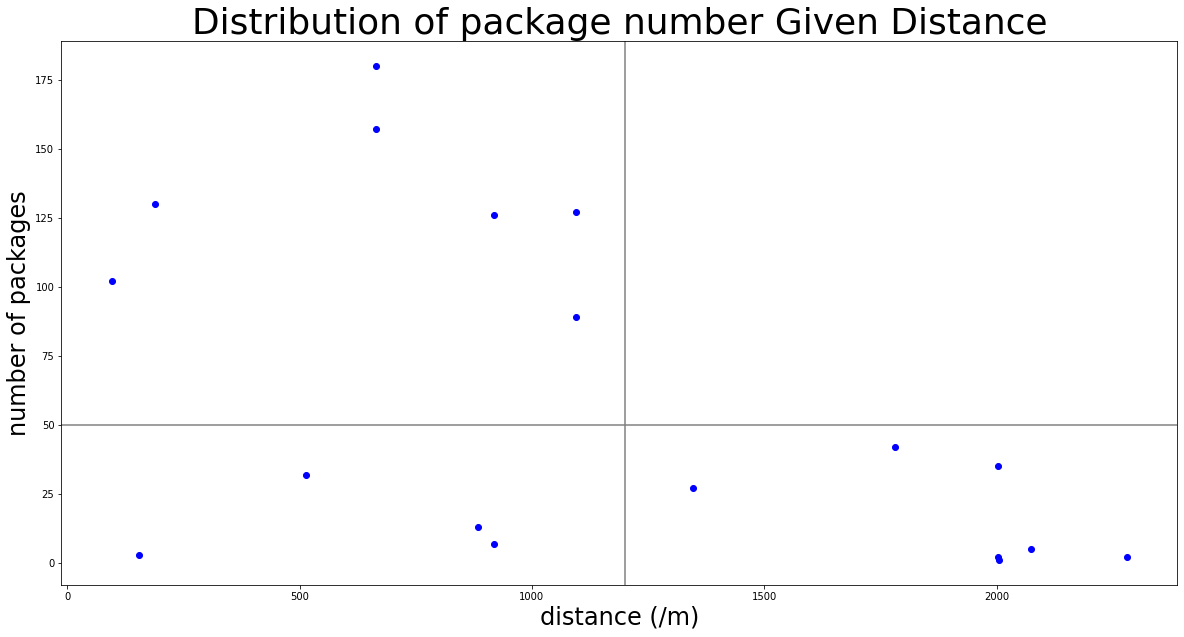

In [49]:
import numpy as np
from matplotlib import pyplot as plt


records = np.array(records).T

fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.axis('auto')
ax.scatter(records[0], records[1], color='blue')
ax.set_title('Distribution of package number Given Distance', fontsize=36)
ax.set_xlabel('distance (/m)', fontsize=24)
ax.set_ylabel('number of packages', fontsize=24)
ax.axhline(y=50, color='grey')
ax.axvline(x=1200, color='grey')
plt.savefig('dist_RSSI.png')
plt.show()

# fig, ax = plt.subplots(1,1, figsize=(20,10))
# ax.axis('auto')
# ax.scatter(records[0], records[2], color='blue')
# ax.set_title('Distribution of package size Given Distance', fontsize=36)
# ax.set_xlabel('distance (/m)', fontsize=24)
# ax.set_ylabel('packet number', fontsize=24)
# ax.axhline(y=50, color='grey')
# ax.axvline(x=1000, color='grey')
# plt.savefig('dist_RSSI.png')
# plt.show()

In [58]:
rssi_records = []
for item in gt_distribution:
    s_date = gt_distribution[item]['date'][0]
    e_date = gt_distribution[item]['date'][1]
    # print(s_date, e_date)
    duration = date2ts(e_date) - date2ts(s_date)
    raw_data = data[(data.ts > date2ts(s_date))&(data.ts < date2ts(e_date))]
    print(item, raw_data.shape, duration)
    gt_loc = gt_distribution[item]['coor']

    routers = raw_data['router'].drop_duplicates(keep='first').tolist()
    for r in routers:
        r_data = raw_data[(raw_data.router == r)]
        size = len(r_data)
        rssi = r_data.rssi
        if r[2:] in router_info.keys():
            router_info[r[2:]]['lat']  = abs(router_info[r[2:]]['lat'])
            rssi_records.extend([(distance(geo2meter(gt_loc), geo2meter((router_info[r[2:]]['lat'],router_info[r[2:]]['lon']))), i)for i in rssi])

diamond_200m (335, 4) 600.0
dayoujie_500m (371, 4) 600.0
huangdaxian_1000m (364, 4) 600.0
fuhaodongfang_1500m (301, 4) 600.0
songhuangtai_2000m (156, 4) 600.0


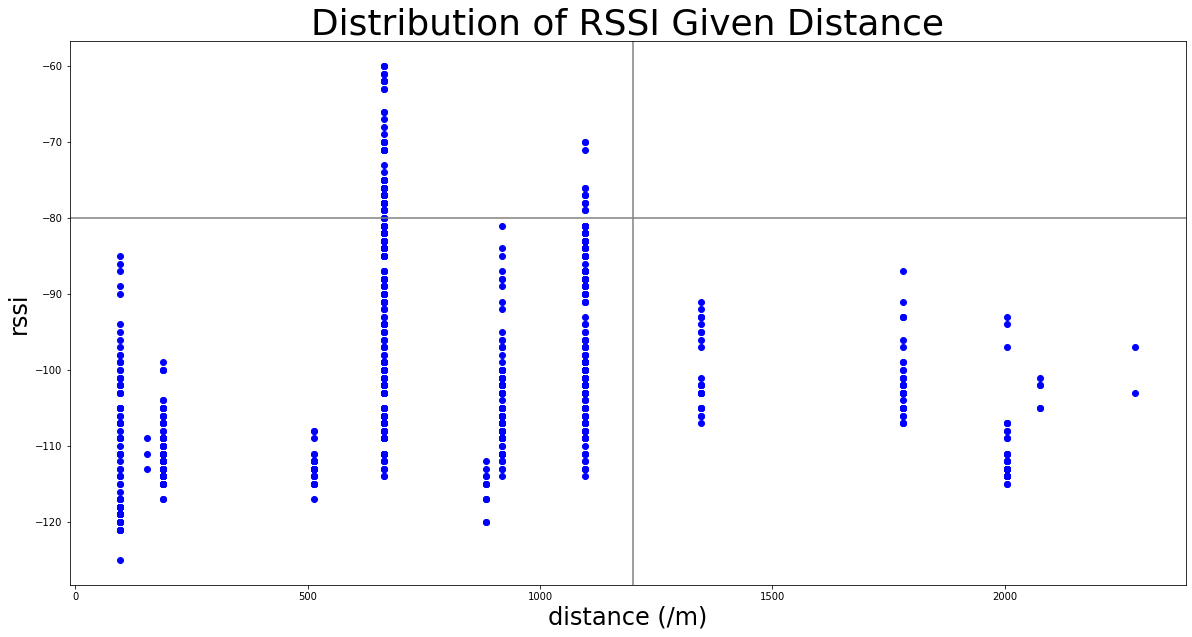

In [62]:
rr = np.array(rssi_records).T
fig, ax = plt.subplots(1,1, figsize=(20,10))
ax.axis('auto')
ax.scatter(rr[0], rr[1], color='blue')
ax.set_title('Distribution of RSSI Given Distance', fontsize=36)
ax.set_xlabel('distance (/m)', fontsize=24)
ax.set_ylabel('rssi', fontsize=24)
ax.axhline(y=-80, color='grey')
ax.axvline(x=1200, color='grey')
plt.savefig('dist_RSSI.png')
plt.show()